# Makemore 2

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
import torch.nn.functional as F

In [3]:
%matplotlib inline

In [4]:
words =  open("names.txt",'r').read().splitlines()

In [5]:
chars =  list(set(''.join(words)))
stoi = {ch:i for i,ch in enumerate(chars)}
stoi['.'] = 0
itos = { i:ch for ch,i in stoi.items()}

In [6]:
print(itos)

{0: '.', 1: 'b', 2: 'x', 3: 'c', 4: 'o', 5: 'q', 6: 'h', 7: 's', 8: 'e', 9: 'v', 10: 'p', 11: 'd', 12: 'w', 13: 'g', 14: 'r', 15: 'j', 16: 'y', 17: 'i', 18: 'z', 19: 'f', 20: 'n', 21: 'k', 22: 'm', 23: 't', 24: 'l', 25: 'a'}


In [138]:
import random
random.seed(42)
random.shuffle(words)

In [170]:
# create the dataset with block_size and label
def dataset(words,block_size=3):
    context = [0]*block_size
    Y = []
    X = []
    for w in words:
        # print(w)
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[x]for x in context])," ----> ",itos[ix])
            context = context[1:] + [ix]

    return torch.tensor(X),torch.tensor(Y)

In [175]:
emb_dim = 10
b_size=5
n=200
vocab_size = 27
batch_size = 32

### Train, Val, Test split

In [176]:
X,Y = dataset(words,block_size=b_size)

In [177]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = dataset(words[:n1],block_size=b_size)
Xdev,Ydev = dataset(words[n1:n2],block_size=b_size)
Xtest,Ytest = dataset(words[n2:],block_size=b_size)

In [178]:
print(Xtr.shape,Ytr.shape)
print(Xdev.shape,Ydev.shape)
print(Xtest.shape,Ytest.shape)

torch.Size([182519, 5]) torch.Size([182519])
torch.Size([22806, 5]) torch.Size([22806])
torch.Size([22821, 5]) torch.Size([22821])


### Parameters init

In [179]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn(vocab_size,emb_dim)
W1 = torch.randn((emb_dim*b_size,n))
b1 = torch.randn(n)
W2 = torch.randn(n,vocab_size)
b2 = torch.randn(vocab_size)
parameters = [C,W1,b1,W2,b2]

# each of the set of parameters needs to be set this to avoid getting erorr
for p in parameters:
    p.requires_grad = True

In [180]:
sum(p.nelement() for p in parameters) # total number of parameters

15897

### Forward Pass

In [181]:
lre = torch.linspace(-3,1,1000)
lrs = 10**lre

In [182]:
lres = []
lossi = []
stepi=[]
for i in range(200000):
    ix = torch.randint(0,X.shape[0],(batch_size,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,emb_dim*b_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ix])
    # print(loss.item())

    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # lres.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)

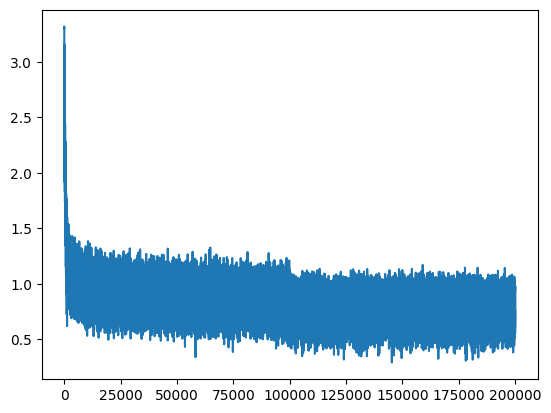

In [183]:
plt.plot(stepi,torch.tensor(lossi).log())

### training loss 

In [184]:

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dim*b_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1805, grad_fn=<NllLossBackward0>)

### val loss

In [185]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,emb_dim*b_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
print(loss.item())

2.192669630050659


### test loss

In [186]:
emb = C[Xtest]
h = torch.tanh(emb.view(-1,emb_dim*b_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytest)
print(loss.item())

2.1796822547912598


In [187]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * b_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

cisylelin.
yvilie.
qgzyl.
qvian.
ymsin.
qpz.
erirhoy.
ymen.
ysiev.
yivariyace.
vvior.
wessyn.
wrs.
iviniel.
ivir.
qmse.
ivixi.
iisney.
yvizalilyn.
qisok.
